<a href="https://colab.research.google.com/github/abhi1021/resnet50-imagenet-1k/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training ResNet50 on ImageNette2-160

**Configuration:**
- Model: ResNet50 (PyTorch)
- Dataset: ImageNette2-160 (10 classes from ImageNet)
- Epochs: 3
- Batch Size: 128
- Scheduler: OneCycle Learning Rate Policy

## Clone Repository

In [1]:
!git clone https://github.com/abhi1021/resnet50-imagenet-1k.git
%cd resnet50-imagenet-1k

Cloning into 'resnet50-imagenet-1k'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 221 (delta 99), reused 177 (delta 60), pack-reused 0 (from 0)
Receiving objects: 100% (221/221), 984.82 KiB | 3.88 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/resnet50-imagenet-1k


## Download Dataset

In [2]:
# Download ImageNette2-160 dataset
print("Downloading ImageNette2-160 dataset...")
!wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
print("✓ Download complete")

print("\nExtracting dataset...")
!tar -xzf imagenette2-160.tgz
print("✓ Extraction complete")

# Count images
import os
train_count = sum([len(files) for r, d, files in os.walk('imagenette2-160/train')])
val_count = sum([len(files) for r, d, files in os.walk('imagenette2-160/val')])
print(f"\n✓ Dataset ready:")
print(f"  Training images: {train_count}")
print(f"  Validation images: {val_count}")

✓ Download complete

Extracting dataset...
✓ Extraction complete

✓ Dataset ready:
  Training images: 9470
  Validation images: 3925


In [3]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Setup HuggingFace Token (Optional)

In [4]:
# Setup HuggingFace token (optional)
HF_TOKEN = None
HF_REPO_ID = None

try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    HF_REPO_ID = 'your-username/imagenette-resnet50'
    print("✓ HuggingFace token found")
except:
    print("ℹ️ Training without HuggingFace upload")

ℹ️ Training without HuggingFace upload


## Start Training

In [5]:
# Build training command
cmd = "python train.py --epochs 20 --batch-size 128 --model resnet50-pytorch --dataset imagenet --data-dir ./imagenette2-160 --num-classes 10 --scheduler onecycle --lr-finder"

# Add HuggingFace parameters if available
if HF_TOKEN and HF_REPO_ID:
    cmd += f" --hf-token {HF_TOKEN} --hf-repo {HF_REPO_ID}"

print(f"Running: {cmd}\n")
print("="*70)

# Run training
!{cmd}

Running: python train.py --epochs 20 --batch-size 128 --model resnet50-pytorch --dataset imagenet --data-dir ./imagenette2-160 --num-classes 10 --scheduler onecycle --lr-finder

✓ Loaded config from: ./config.json

TRAINING CONFIGURATION
Model: resnet50-pytorch
Dataset: imagenet
Data Directory: ./imagenette2-160
Number of Classes: 10
Epochs: 20
Batch Size: 128
Optimizer: sgd
Scheduler: onecycle
Augmentation: strong
MixUp: True (alpha=0.2)
Label Smoothing: 0.1
Mixed Precision: True
Gradient Clipping: 1.0
LR Finder: True
Target Accuracy Early Stopping: Disabled


GPU DETECTION AND CONFIGURATION
✓ CUDA is available
✓ Number of GPUs: 1
  GPU 0: Tesla T4
    Memory: 14.74 GB
✓ Using GPU: Tesla T4
✓ CUDA Version: 12.6
✓ PyTorch Version: 2.8.0+cu126


📊 Dataset: ImageNet
   Classes: 10
   Train samples: 9469
   Test samples: 3925

Loading datasets...
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total

## View Results

In [6]:
import glob
import json
import os

# Find the latest checkpoint directory
checkpoint_dirs = sorted(glob.glob('checkpoint_*'), reverse=True)

if checkpoint_dirs:
    latest_checkpoint = checkpoint_dirs[0]
    print(f"\n{'='*70}")
    print(f"LATEST CHECKPOINT: {latest_checkpoint}")
    print(f"{'='*70}\n")

    # Load and display metrics
    metrics_file = os.path.join(latest_checkpoint, 'metrics.json')
    if os.path.exists(metrics_file):
        with open(metrics_file, 'r') as f:
            metrics = json.load(f)

        print(f"📊 TRAINING RESULTS")
        print(f"{'='*70}")
        print(f"Best Test Accuracy: {metrics['best_test_accuracy']:.2f}%")
        print(f"Best Epoch: {metrics['best_epoch']}")
        print(f"Total Epochs Trained: {len(metrics['epochs'])}")
        print(f"\nFinal Metrics:")
        print(f"  - Train Accuracy: {metrics['train_accuracies'][-1]:.2f}%")
        print(f"  - Test Accuracy: {metrics['test_accuracies'][-1]:.2f}%")
        print(f"  - Train Loss: {metrics['train_losses'][-1]:.4f}")
        print(f"  - Test Loss: {metrics['test_losses'][-1]:.4f}")
        print(f"{'='*70}")

    # List saved files
    print(f"\n📁 Saved Files in {latest_checkpoint}:")
    for file in sorted(os.listdir(latest_checkpoint)):
        file_path = os.path.join(latest_checkpoint, file)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
            print(f"  - {file} ({file_size:.2f} MB)")

    print(f"\n{'='*70}")
else:
    print("⚠ No checkpoint directories found.")


LATEST CHECKPOINT: checkpoint_1

📊 TRAINING RESULTS
Best Test Accuracy: 73.17%
Best Epoch: 20
Total Epochs Trained: 20

Final Metrics:
  - Train Accuracy: 59.03%
  - Test Accuracy: 73.17%
  - Train Loss: 1.5046
  - Test Loss: 0.9020

📁 Saved Files in checkpoint_1:
  - best_model.pth (179.86 MB)
  - checkpoint_epoch10.pth (179.87 MB)
  - checkpoint_epoch20.pth (179.87 MB)
  - config.json (0.00 MB)
  - lr_finder_plot.png (0.08 MB)
  - metrics.json (0.00 MB)
  - training_curves.png (0.46 MB)



## Visualize Training Curves

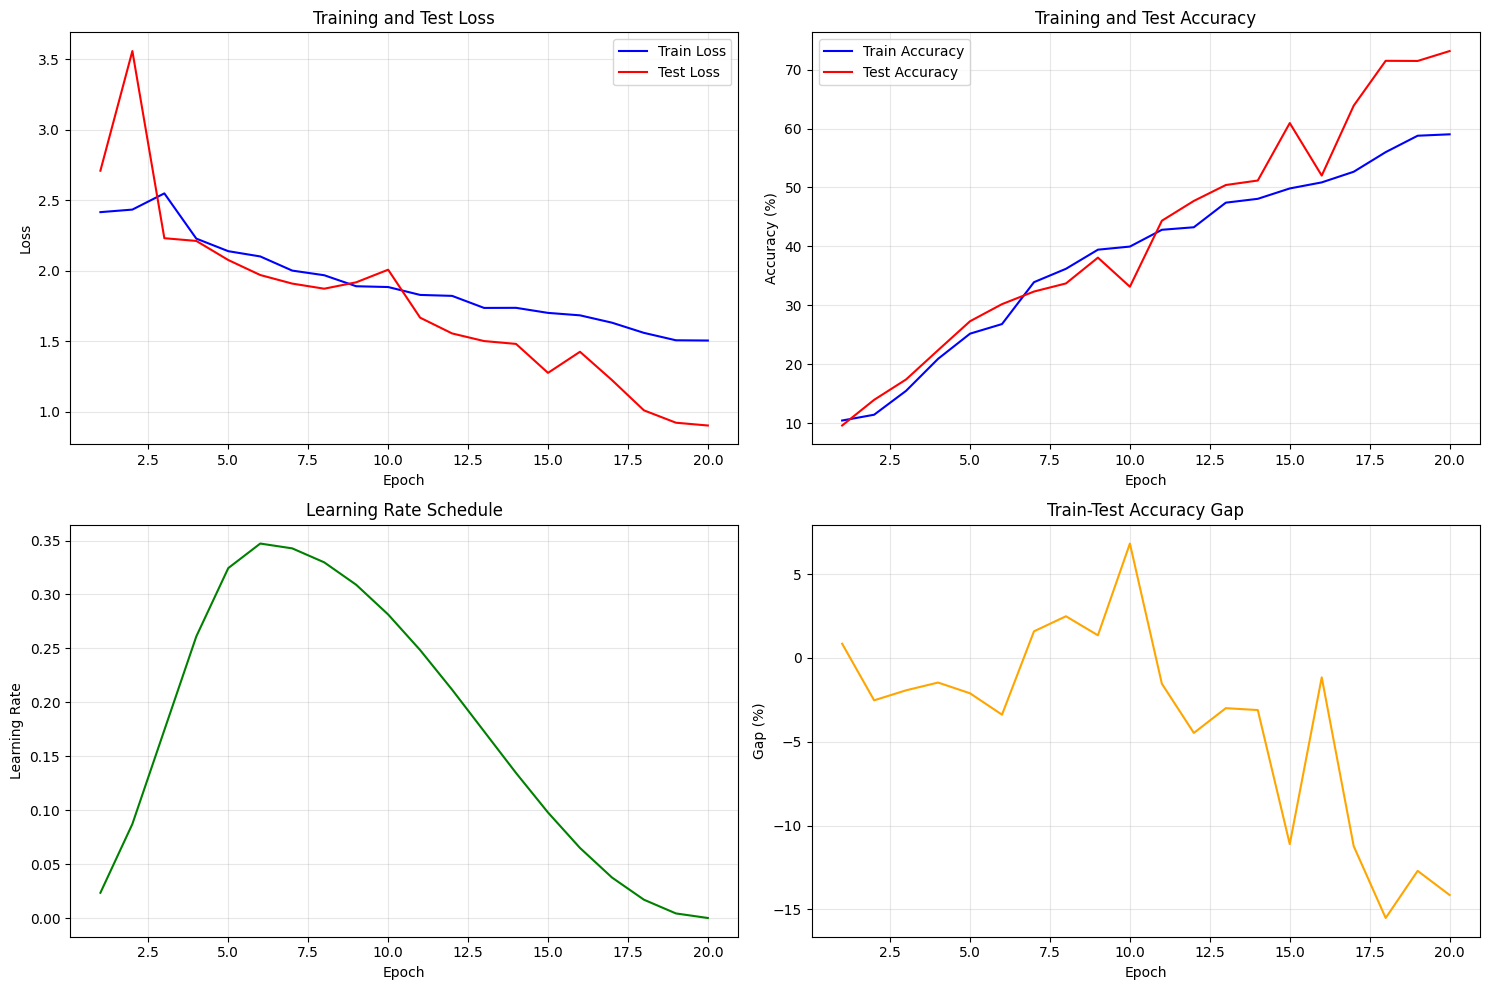


📊 TRAINING SUMMARY
Best Test Accuracy: 73.17% (Epoch 20)
Final Test Accuracy: 73.17%
Final Train-Test Gap: -14.14%
Min Test Loss: 0.9020
Max Learning Rate: 0.347168
Min Learning Rate: 0.000001


In [7]:
import matplotlib.pyplot as plt
import json

if checkpoint_dirs:
    latest_checkpoint = checkpoint_dirs[0]
    metrics_file = os.path.join(latest_checkpoint, 'metrics.json')

    if os.path.exists(metrics_file):
        with open(metrics_file, 'r') as f:
            metrics = json.load(f)

        epochs = metrics['epochs']

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: Loss
        axes[0, 0].plot(epochs, metrics['train_losses'], label='Train Loss', color='blue')
        axes[0, 0].plot(epochs, metrics['test_losses'], label='Test Loss', color='red')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training and Test Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Accuracy
        axes[0, 1].plot(epochs, metrics['train_accuracies'], label='Train Accuracy', color='blue')
        axes[0, 1].plot(epochs, metrics['test_accuracies'], label='Test Accuracy', color='red')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].set_title('Training and Test Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Learning Rate
        axes[1, 0].plot(epochs, metrics['learning_rates'], color='green')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 4: Accuracy Gap
        accuracy_gap = [train - test for train, test in zip(metrics['train_accuracies'], metrics['test_accuracies'])]
        axes[1, 1].plot(epochs, accuracy_gap, color='orange')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Gap (%)')
        axes[1, 1].set_title('Train-Test Accuracy Gap')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f"\n📊 TRAINING SUMMARY")
        print(f"{'='*70}")
        print(f"Best Test Accuracy: {max(metrics['test_accuracies']):.2f}% (Epoch {metrics['test_accuracies'].index(max(metrics['test_accuracies'])) + 1})")
        print(f"Final Test Accuracy: {metrics['test_accuracies'][-1]:.2f}%")
        print(f"Final Train-Test Gap: {accuracy_gap[-1]:.2f}%")
        print(f"Min Test Loss: {min(metrics['test_losses']):.4f}")
        print(f"Max Learning Rate: {max(metrics['learning_rates']):.6f}")
        print(f"Min Learning Rate: {min(metrics['learning_rates']):.6f}")
        print(f"{'='*70}")
    else:
        print("⚠ Metrics file not found.")

## Download Checkpoint

In [8]:
from google.colab import files
import shutil

if checkpoint_dirs:
    latest_checkpoint = checkpoint_dirs[0]

    # Create a zip file of the checkpoint directory
    zip_filename = f"{latest_checkpoint}.zip"
    shutil.make_archive(latest_checkpoint, 'zip', latest_checkpoint)

    print(f"✓ Created {zip_filename}")
    print(f"  Size: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")
    print("\nDownloading...")

    # Download the zip file
    files.download(zip_filename)

    print("✓ Download complete!")
else:
    print("⚠ No checkpoint directories found.")

✓ Created checkpoint_1.zip
  Size: 500.98 MB

Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download complete!
